In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import vartools as vt

import matplotlib.pyplot as plt
from IPython.display import display
from scipy.optimize import minimize, shgo
from sklearn.linear_model import LinearRegression

## Obtención de datos

In [2]:
tickers = ['AAPL', 'WMT', 'JPM', 'PG', 'META', 'V']
benchmark = 'SPY'

price = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Close'][tickers]
volume = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Volume'][tickers]

benchmark_data = yf.download(benchmark, start='2021-01-01', end='2025-03-12', progress=False)['Close']

rt = price.pct_change().dropna()
rt_benchmark = benchmark_data.pct_change().dropna()

YF.download() has changed argument auto_adjust default to True


In [3]:
print(f'Precios de los activos')
display(price.head())
print()

print(f'Volumen de los activos')
display(volume.head());

Precios de los activos


Ticker,AAPL,WMT,JPM,PG,META,V
Date,,,,,,
2021-01-04,126.4053,46.0713,112.3085,124.0700,267.6784,211.1414
2021-01-05,127.9681,45.8261,112.9196,124.8622,269.6989,207.9902
2021-01-06,123.6605,46.1122,118.2218,126.1766,262.0748,206.1576
2021-01-07,127.8801,46.1091,122.1041,124.9973,267.4793,207.3115
2021-01-08,128.9839,46.1028,122.2389,124.9432,266.3148,208.9016



Volumen de los activos


Ticker,AAPL,WMT,JPM,PG,META,V
Date,,,,,,
2021-01-04,143301900,32182200,16819900,8330900,15106100,10318300
2021-01-05,97664900,26498100,13731200,6856400,9871600,6869700
2021-01-06,155088000,21918900,24909100,10578000,24354100,7206200
2021-01-07,109578200,20538000,21940400,7355400,15789800,10967900
2021-01-08,105158200,24478200,12035100,7448500,18528300,6513000


In [4]:
pd.set_option('display.float_format', '{:.2%}'.format)
stats_df = pd.DataFrame({
    'Rendimiento Anual': rt.mean() * 252,
    'Volatilidad Anual': rt.std() * np.sqrt(252),
})
stats_df.T

Ticker,AAPL,WMT,JPM,PG,META,V
Rendimiento Anual,16.96%,17.44%,20.03%,9.45%,29.47%,13.41%
Volatilidad Anual,26.74%,20.19%,24.16%,17.05%,44.15%,22.53%


## Optimización y Evolución de Portafolios

### Funciones de Optimización

In [5]:
def portfolio_return(returns, weights):
    return np.dot(returns, weights)

In [6]:
class PortfolioOptimizer:
    def __init__(self, returns: pd.DataFrame, price: pd.DataFrame = None, volume: pd.DataFrame = None, rt_benchmark: pd.DataFrame = None,
                 rf: float = None, portfolio_value: float = None):
        """
        Inicializa el optimizador de portafolios.

        Parámetros:
        -----------
        returns : DataFrame
            DataFrame con los rendimientos históricos de los activos.
        rf (opcional): float
            Tasa libre de riesgo anualizada requerido para Sharpe y LVRR.
        price (opcional): DataFrame
            DataFrame con los precios históricos de los activos requerido para LVRR.
        volume (opcional): DataFrame
            DataFrame con los volúmenes históricos de los activos requerido para LVRR
        """
        self.rt = returns
        self.rf = rf
        self.price = price
        self.volume = volume
        self.pv = portfolio_value
        self.rt_benchmark = rt_benchmark

    def opt_sharpe(self) -> np.ndarray:
        """
        Optimiza los pesos de un portafolio para maximizar el Sharpe Ratio.

        Retorna:
        --------
        w_opt_sharpe : ndarray
            Un array con los pesos óptimos de los activos en el portafolio que maximizan el Sharpe Ratio.
        """
        mu = (self.rt.mean() * 252).values
        sigma = self.rt.cov().values
        n_assets = len(self.rt.keys())

        # Función para minimizar (-Sharpe Ratio)
        def neg_sharpe_ratio(w, mu, sigma, rf):
            port_return = np.dot(w.T, mu)
            port_vol = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)
            return -(port_return - rf) / port_vol

        # Restricciones y límites
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        bounds = ((0, 1),) * n_assets
        w0 = np.ones(n_assets) / n_assets

        result = minimize(neg_sharpe_ratio, w0, args=(mu, sigma, self.rf), method='SLSQP', bounds=bounds, constraints=constraints)
        return result.x

    def lvrr(self) -> np.ndarray:
        """
        Optimiza la asignación de activos maximizando el Sharpe Ratio ajustado por liquidez.

        Retorna:
        --------
        lvrr_weights : ndarray
            Vector con los pesos óptimos de cada activo en el portafolio.
        """
        returns = self.price.pct_change().dropna()
        mu = returns.mean() * 252
        sigma = returns.cov()
        n_assets = len(returns.keys())

        # Volumen promedio de los últimos 3 meses
        adv = self.volume.iloc[-90:, :].mean()

        def objective(w):
            H = 1 / (adv * self.price.iloc[-1])
            lr = np.dot(self.pv, np.dot(w.T, H))

            port_return = np.dot(w.T, mu)
            port_vol = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)

            return -(port_return - self.rf) / (port_vol * lr)

        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        bounds = ((0, 1),) * n_assets
        w0 = np.ones(n_assets) / n_assets

        result = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints)
        return result.x

    def semivariance(self) -> np.ndarray:
        """
        Optimiza la asignación de activos minimizando la semivarianza.

        Retorna:
        --------
        weights : ndarray
            Vector con los pesos óptimos de cada activo en el portafolio.
        """
        diff = self.rt - self.rt_benchmark.values
        downside = diff.where(diff < 0, 0).std()
        corr = self.rt.corr()
        S = np.outer(downside, downside) * corr

        n_assets = len(self.rt.keys())

        def objective(w, S):
            return w.T @ S @ w

        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        bounds = ((0, 1),) * n_assets

        result = shgo(objective, bounds, args=(S,), constraints=constraints)
        return result.x

    def omega(self) -> np.ndarray:
        """
        Optimiza la asignación de activos maximizando el ratio Omega.

        Retorna:
        --------
        weights : ndarray
            Vector con los pesos óptimos de cada activo en el portafolio.
        """
        diff = self.rt - self.rt_benchmark.values
        downside = diff.where(diff < 0, 0).std()
        upside = diff.where(diff > 0, 0).std()

        omega = upside / downside
        n_assets = len(omega)

        def objective(w, omega):
            return -np.dot(w.T, omega)

        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        bounds = ((0, 1),) * n_assets
        w0 = np.ones(n_assets) / n_assets

        result = minimize(objective, w0, args=(omega,), method='SLSQP', bounds=bounds, constraints=constraints)
        return result.x

## Backtest Estático

In [7]:
pd.reset_option('display.float_format')

rf = 0.05
pv = 1_000_000.0

start_date = '2021-01-01'
end_date = '2023-12-31'

start_test = '2024-01-01'
end_test = '2025-03-12'
#end_test = datetime.datetime.today().strftime('%Y-%m-%d')

benchmark_train = benchmark_data.loc[start_date:end_date]
benchmark_test = benchmark_data.loc[start_test:end_test]

price_train = price.loc[start_date:end_date]
price_test = price.loc[start_test:end_test]

volume_train = volume.loc[start_date:end_date]
volume_test = volume.loc[start_test:end_test]

rt_train = price_train.pct_change().dropna()
rt_test = price_test.pct_change().dropna()
rt_benchmark_train = benchmark_train.pct_change().dropna()
rt_benchmark_test = benchmark_test.pct_change().dropna()

### Máximo Ratio de Sharpe

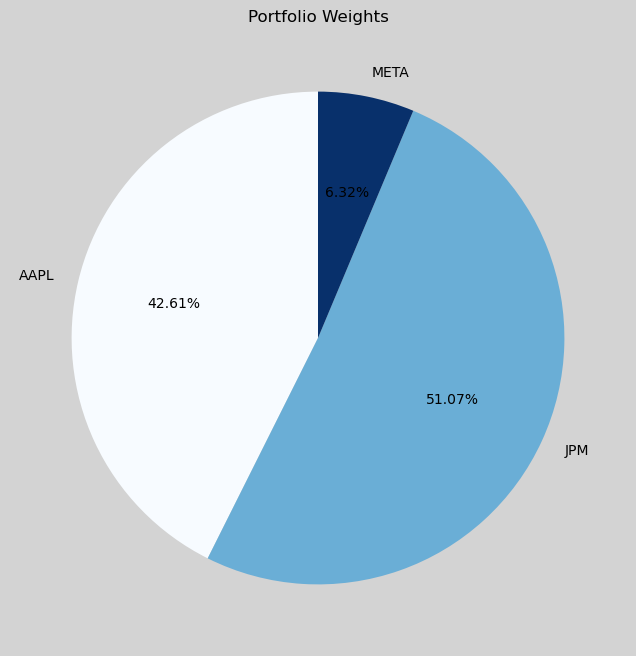

In [8]:
w_sharpe = PortfolioOptimizer(returns = rt_train, rf = rf).opt_sharpe()
vt.plot_weights(tickers, w_sharpe)

### Liquidity Variance Return Ratio (LVRR)

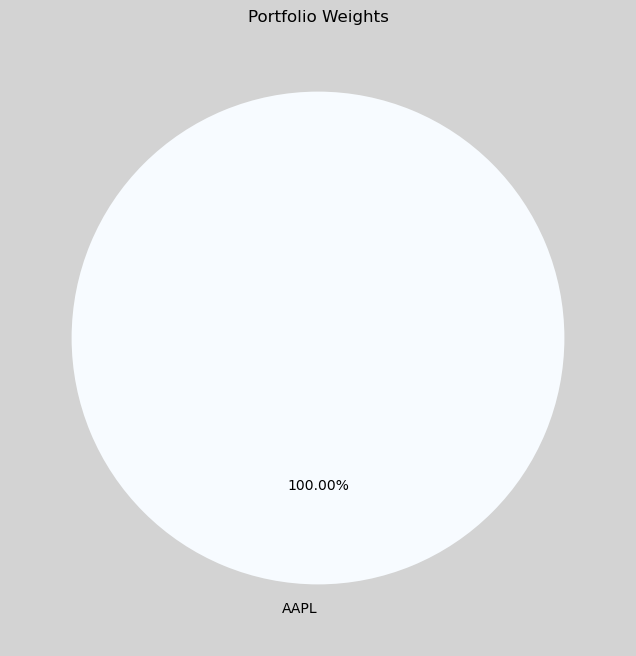

In [9]:
w_lvrr = PortfolioOptimizer(returns=rt_train, price=price_train, volume=volume_train, rf=rf, portfolio_value=pv).lvrr()
vt.plot_weights(tickers, w_lvrr)

### Target Semivariance

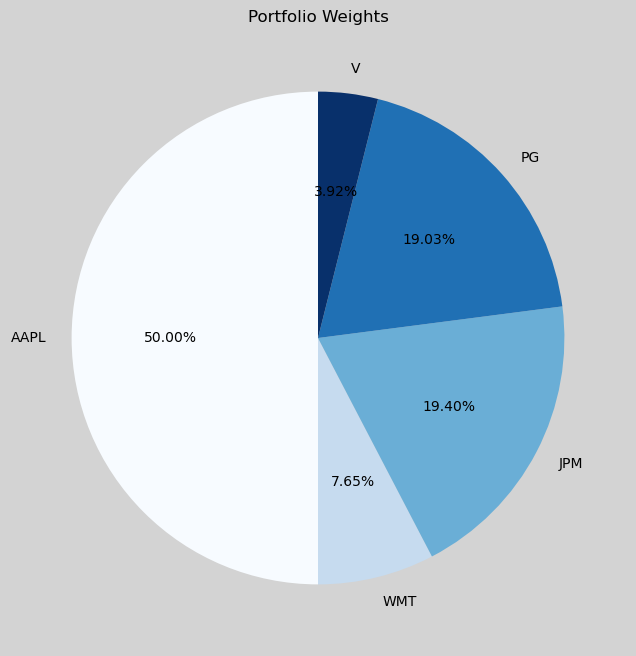

In [10]:
w_semivariance = PortfolioOptimizer(returns=rt_train, rt_benchmark=rt_benchmark_train).semivariance()
vt.plot_weights(tickers, w_semivariance)

### Omega

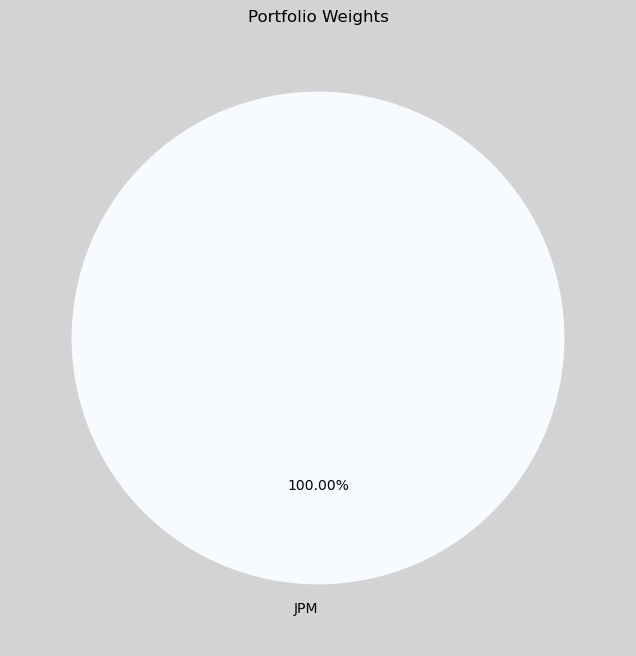

In [11]:
w_omega = PortfolioOptimizer(returns=rt_train, rt_benchmark=rt_benchmark_train).omega()
vt.plot_weights(tickers, w_omega)

### Gráfica

In [12]:
strats = [w_sharpe, w_lvrr, w_semivariance, w_omega]
strats_returns = [portfolio_return(rt_test, w) for w in strats]

# Calcular los retornos acumulados y el dinero acumulado
cumulative_returns = [(1 + r).cumprod() for r in strats_returns]
cumulative_money = [pv * cr for cr in cumulative_returns]

# Crear DataFrame para rendimientos y dinero acumulado
cumulative_returns_df = pd.DataFrame(cumulative_returns, index=['Sharpe', 'LVRR', 'Semivariance', 'Omega']).T
cumulative_money_df = pd.DataFrame(cumulative_money, index=['Sharpe', 'LVRR', 'Semivariance', 'Omega']).T

# Comparar con el benchmark
cumulative_benchmark_returns = (1 + rt_benchmark_test).cumprod().squeeze()
cumulative_returns_df['Benchmark'] = cumulative_benchmark_returns.values
cumulative_money_df['Benchmark'] = pv * cumulative_benchmark_returns.values

# DataFrame con los pesos óptmimos
pd.set_option('display.float_format', '{:.2%}'.format)
df_optimal = pd.DataFrame({
    'Ticker': tickers,
    'Sharpe': w_sharpe,
    'LVRR': w_lvrr,
    'Semivariance': w_semivariance,
    'Omega': w_omega
})
df_optimal.set_index('Ticker', inplace=True)

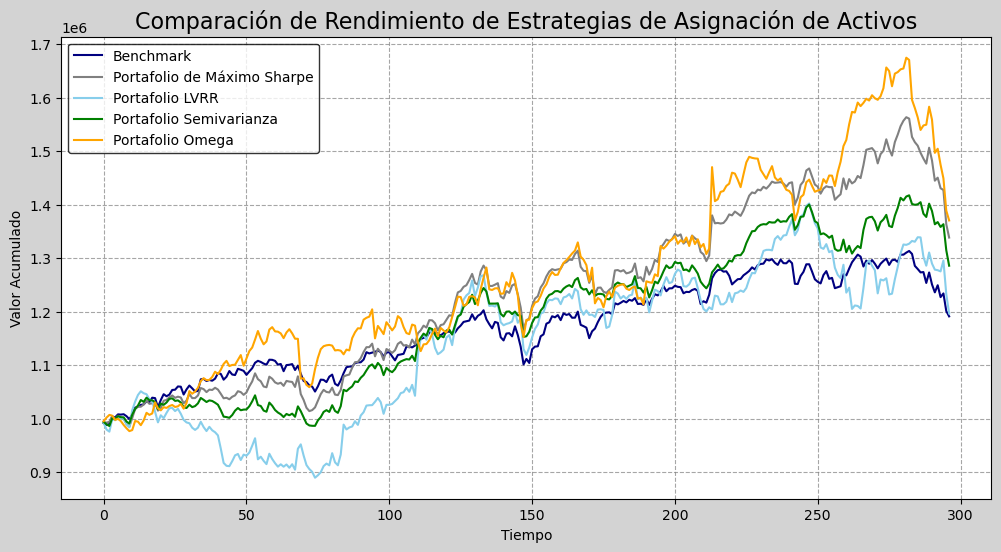

In [13]:
plt.figure(figsize=(12, 6))

plt.plot(cumulative_money_df['Benchmark'], label='Benchmark', c = 'navy')
plt.plot(cumulative_money_df['Sharpe'], label='Portafolio de Máximo Sharpe', c = 'gray')
plt.plot(cumulative_money_df['LVRR'], label='Portafolio LVRR', c = 'skyblue')
plt.plot(cumulative_money_df['Semivariance'], label='Portafolio Semivarianza', c = 'green')
plt.plot(cumulative_money_df['Omega'], label='Portafolio Omega', c = 'orange')

plt.title('Comparación de Rendimiento de Estrategias de Asignación de Activos', fontsize=16)
plt.xlabel('Tiempo')
plt.ylabel('Valor Acumulado')

plt.legend(frameon=True, facecolor='white', edgecolor='black', loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.7);

In [14]:
print(f'Pesos óptmio de las estrategias')
display(df_optimal.T)
print()

pd.reset_option('display.float_format')
print(f'Evolución de los rendimientos')
display(cumulative_returns_df)

print()

print(f'Evolución del valor del portafolio')
display(cumulative_money_df)

for i in cumulative_money_df.columns:
    print(f'El valor final del portafolio {i} es de {cumulative_money_df[i].iloc[-1]:,.2f}')

Pesos óptmio de las estrategias


Ticker,AAPL,WMT,JPM,PG,META,V
Sharpe,42.61%,0.00%,51.07%,0.00%,6.32%,0.00%
LVRR,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Semivariance,50.00%,7.65%,19.40%,19.03%,0.00%,3.92%
Omega,0.00%,0.00%,100.00%,0.00%,0.00%,0.00%



Evolución de los rendimientos


,Sharpe,LVRR,Semivariance,Omega,Benchmark
0,0.994251,0.992512,0.994129,0.995642,0.991833
1,0.992724,0.979907,0.989643,1.002249,0.988639
2,0.994443,0.975975,0.986570,1.007277,0.989993
3,1.005148,0.999569,1.001001,1.005816,1.004126
4,0.999902,0.997307,0.999746,0.997864,1.002602
...,...,...,...,...,...
292,1.450322,1.277502,1.367400,1.504338,1.249422
293,1.430569,1.275280,1.358269,1.474494,1.227243
294,1.427306,1.295547,1.363392,1.449016,1.234121
295,1.363566,1.232740,1.314790,1.388850,1.201250



Evolución del valor del portafolio


,Sharpe,LVRR,Semivariance,Omega,Benchmark
0,9.942514e+05,9.925123e+05,9.941291e+05,9.956417e+05,9.918333e+05
1,9.927236e+05,9.799073e+05,9.896435e+05,1.002249e+06,9.886385e+05
2,9.944425e+05,9.759749e+05,9.865701e+05,1.007277e+06,9.899926e+05
3,1.005148e+06,9.995690e+05,1.001001e+06,1.005816e+06,1.004126e+06
4,9.999022e+05,9.973066e+05,9.997459e+05,9.978635e+05,1.002602e+06
...,...,...,...,...,...
292,1.450322e+06,1.277502e+06,1.367400e+06,1.504338e+06,1.249422e+06
293,1.430569e+06,1.275280e+06,1.358269e+06,1.474494e+06,1.227243e+06
294,1.427306e+06,1.295547e+06,1.363392e+06,1.449016e+06,1.234121e+06
295,1.363566e+06,1.232740e+06,1.314790e+06,1.388850e+06,1.201250e+06


El valor final del portafolio Sharpe es de 1,338,482.29
El valor final del portafolio LVRR es de 1,196,756.79
El valor final del portafolio Semivariance es de 1,285,916.06
El valor final del portafolio Omega es de 1,370,428.93
El valor final del portafolio Benchmark es de 1,191,264.07


### Métricas de desempeño

In [15]:
X = rt_benchmark_test['SPY'].values.reshape(-1, 1)
y = [strats_returns[i] for i in range(len(strats_returns))]
betas = np.array([LinearRegression().fit(X, i).coef_[0] for i in y])

# Cálculo de rendimiento anualizado, volatilidad y Sharpe
port_ret = np.mean(strats_returns, axis=1) * 252
port_vol = np.std(strats_returns, axis=1) * np.sqrt(252)
sharpe = (port_ret - rf) / port_vol

# Cálculo de alpha
alpha = port_ret - (rf + betas * (((rt_benchmark_test.mean()).iloc[0] * 252)-rf))

# Cálculo de el ratio Sortino
down_risk = [np.minimum(i, 0).std() * np.sqrt(252) for i in strats_returns]
sortino = (port_ret - rf) / down_risk

summary = pd.DataFrame({
    'Rendimiento Anual': port_ret,
    'Volatilidad Anual': port_vol,
    'Sharpe Ratio': sharpe,
    'Beta': betas,
    'Alpha': alpha,
    'Sortino Ratio': sortino
})
summary.set_index(pd.Index(['Sharpe', 'LVRR', 'Semivariance', 'Omega']), inplace=True)
summary

,Rendimiento Anual,Volatilidad Anual,Sharpe Ratio,Beta,Alpha,Sortino Ratio
Sharpe,0.261812,0.169246,1.251501,0.925030,0.112700,2.067109
LVRR,0.180376,0.236592,0.551061,0.943594,0.029275,0.931445
Semivariance,0.223271,0.139999,1.237659,0.688383,0.099515,2.076174
Omega,0.295373,0.236752,1.036410,0.845122,0.154822,1.702708


In [16]:
total_return = [cumulative_returns[i][-1] - 1 for i in range(len(cumulative_returns))]
period_years = len(rt_test) / 252
anualized_returns = (np.ones(len(total_return)) + total_return) ** (1 / period_years) - 1
anualized_returns

array([0.28064541, 0.16462692, 0.23784211, 0.3065339 ])

In [17]:
vt.var_weights(price_test, w_sharpe, 99), vt.cvar_weights(price_test, w_sharpe, 99)

(0.02860460975882202, 0.03612559000747828)

In [18]:
vt.var_weights(price_test, w_lvrr, 99), vt.cvar_weights(price_test, w_lvrr, 99)

(0.04041847614429382, 0.04583466981207245)

In [19]:
vt.var_weights(price_test, w_semivariance, 99), vt.cvar_weights(price_test, w_semivariance, 99)

(0.021189951196235957, 0.0301815991629991)

In [20]:
vt.var_weights(price_test, w_omega, 99), vt.cvar_weights(price_test, w_omega, 99)

(0.04459931599979422, 0.053846517953192036)